# Monopoly and Markov Chains


The goal of this project is to use Markov chains to model the game of Monopoly. We aim to answer some simple questions about the game:
- What are the locations visited the most often? 
- After how many turns is the game at an equilibrium?
- Is there a better strategy? Should one alway build hotels? Can we stick to houses?

To ease the analysis we will simplify some of the rules by simplifying the rules to get out of jail, and neglect the effect of the "Chance" and the "Community chest" cards. We will also consider players that always stick to the same strategy.

Most of the following analysis were motivated by two articles from Ian stewarts in the Scientific American, (reproductions from the articles are linked [here](http://www.math.yorku.ca/Who/Faculty/Steprans/Courses/2042/Monopoly/Monopoly.html) or available on the course page).



## Summary of the game

Those short explanations of the game are taken from [this website](http://www.durangobill.com/Monopoly.html). You can as well check the rules on the wikipedia page ([english](https://en.wikipedia.org/wiki/Monopoly_(game)), [german](https://de.wikipedia.org/wiki/Monopoly)). 

### Rules of the game

#### Dice Rolls: 

 - A player rolls **a pair of dice** and moves his board piece (token) clockwise around the board. The number of board spaces he moves is equal to the sum of the dice. 
 - If he stops on a "Chance" or "Community Chest" board space, he picks up a card from the indicated stack, and if instructed, moves his token to a new location. 
 - If he had doubles, he repeats this process. 
 - However, if he has three doubles in a row, he instead goes directly to Jail.

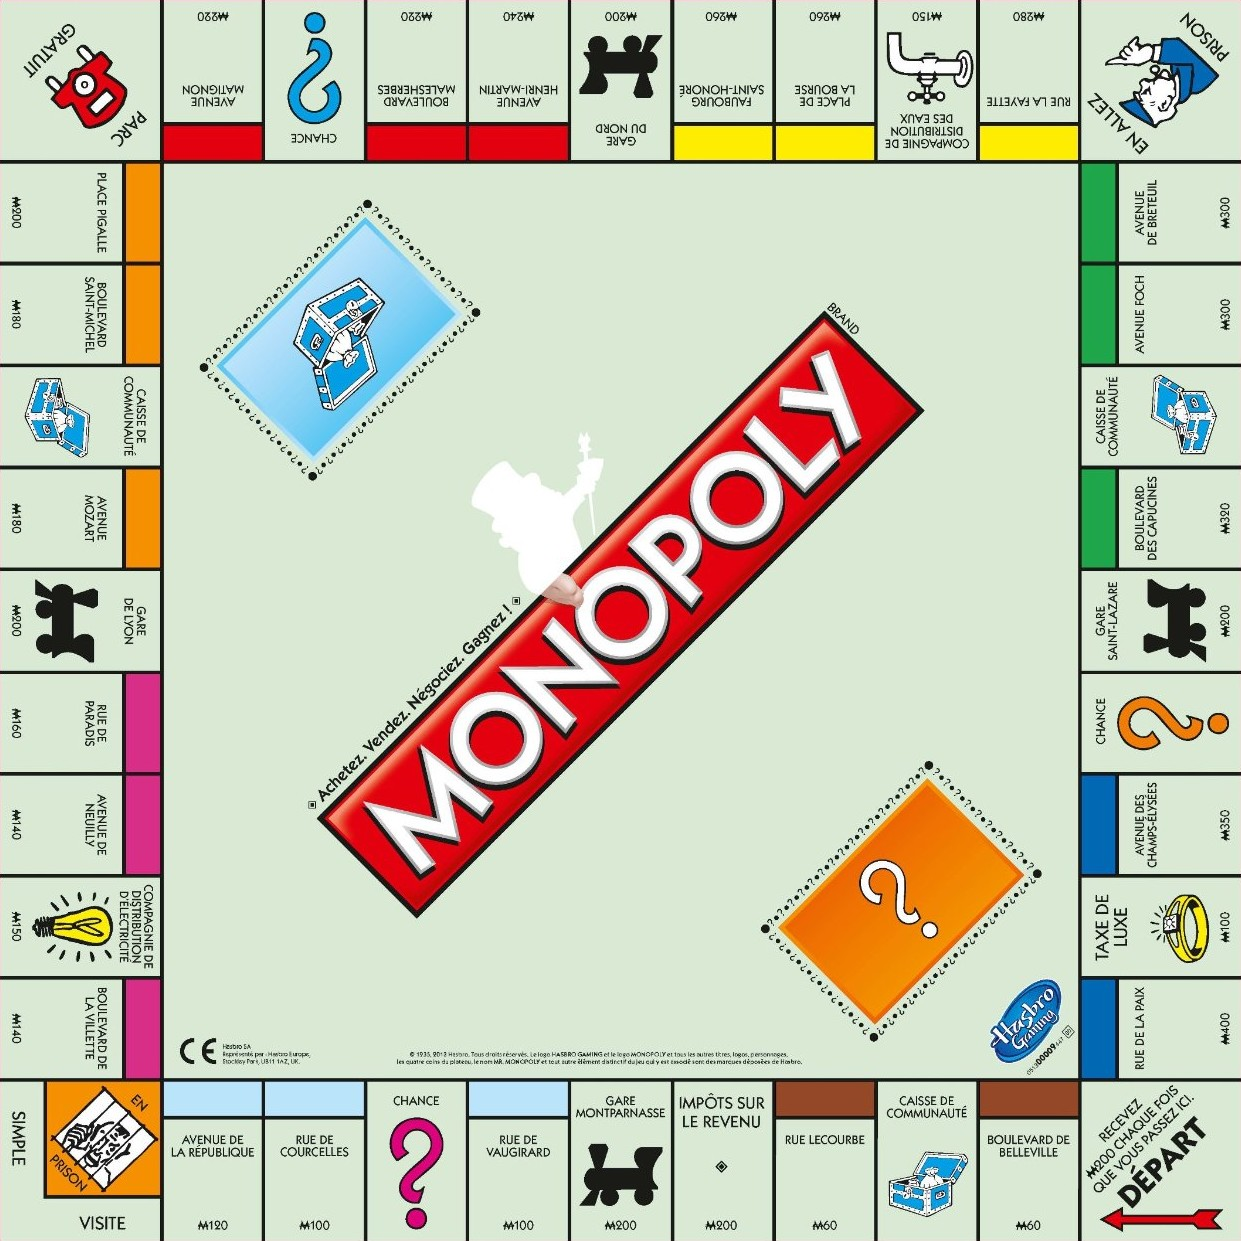



#### Going to Jail: 

If a player is instructed to go to Jail (at any point during his turn), his turn ends regardless of the doubles status. The player will stay at most 3 turns in Jail. He can go out of jail in one of the following manner:
- Paying his way out (50\$). In this case the token goes to "Just visiting" and the player can throw is dice as usual. 
- Using a Chance card. This is similar as paying 50\$.
- Rolling the dice. If there is a double, the player can go out and moves forwards of the number obtained with the dice. Note that in this case the player cannot roll the dice again (the double was "used" to get out of jail).


After the third turn, if the player does not get a double, he *must* pay 50\$ and moves of the number of spaces obtained with the dice.


In [17]:
import os
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

np.set_printoptions(linewidth=1000)
pd.set_option('display.width', 1000)

## 1. Setting up the Markov Chain

In this first part we will set up the parameters for a Markov chain that models the movements of the token of the board from turn to turn. 
We make the following simplification to the rules: 
- Double with the Dice does not allow a second roll.
- We do not consider the cards in the Chance and Community chest slots.
- When getting into Jail, the player always pays 50\$ at the first turn to get out of jail.


We start by constructing the markov chain.

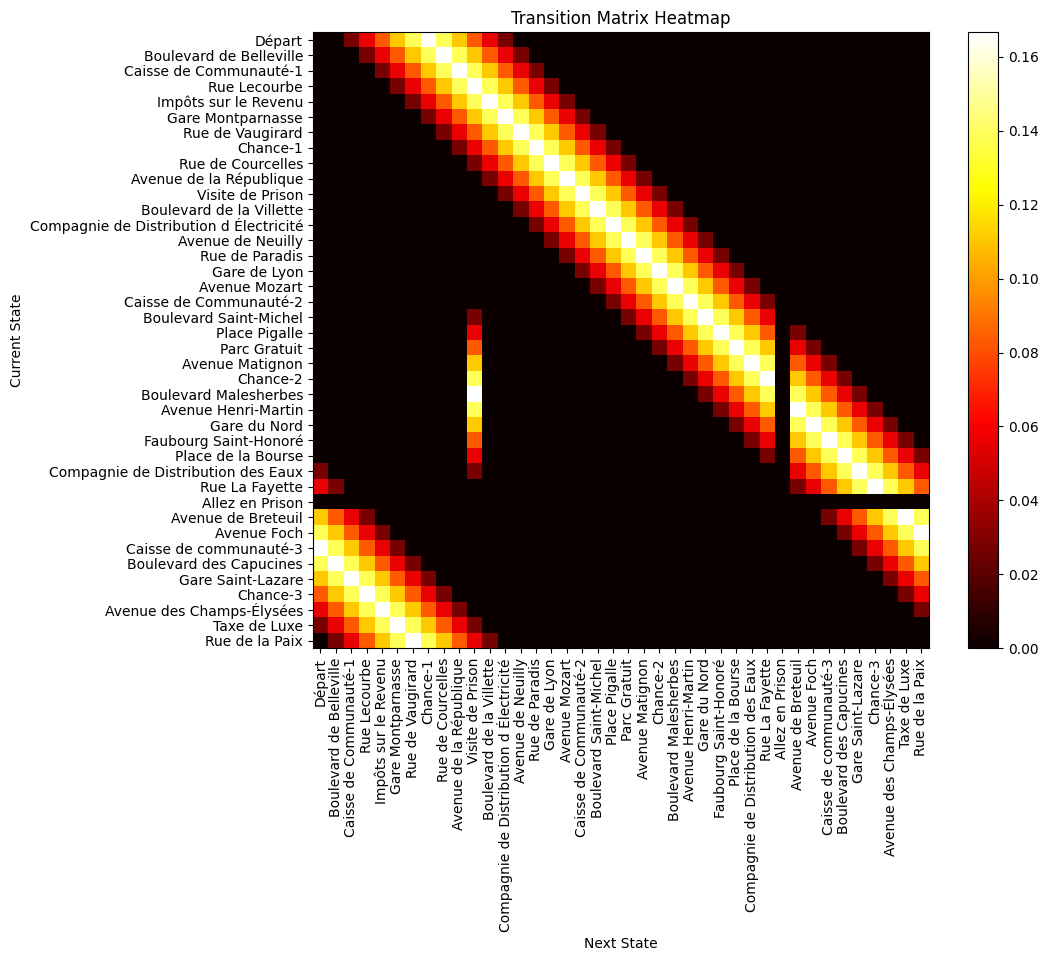

In [140]:

squares = [
    "Départ",
    "Boulevard de Belleville",
    "Caisse de Communauté-1",
    "Rue Lecourbe",
    "Impôts sur le Revenu",
    "Gare Montparnasse",
    "Rue de Vaugirard",
    "Chance-1",
    "Rue de Courcelles",
    "Avenue de la République",
    "Visite de Prison", # Just Visiting and being in Jail are the same square here
    "Boulevard de la Villette",
    "Compagnie de Distribution d Électricité",
    "Avenue de Neuilly",
    "Rue de Paradis",
    "Gare de Lyon",
    "Avenue Mozart",
    "Caisse de Communauté-2",
    "Boulevard Saint-Michel",
    "Place Pigalle",
    "Parc Gratuit",
    "Avenue Matignon",
    "Chance-2",
    "Boulevard Malesherbes",
    "Avenue Henri-Martin",
    "Gare du Nord",
    "Faubourg Saint-Honoré",
    "Place de la Bourse",
    "Compagnie de Distribution des Eaux",
    "Rue La Fayette",
    "Allez en Prison", # Go to Jail
    "Avenue de Breteuil",
    "Avenue Foch",
    "Caisse de communauté-3",
    "Boulevard des Capucines",
    "Gare Saint-Lazare",
    "Chance-3",
    "Avenue des Champs-Élysées",
    "Taxe de Luxe",
    "Rue de la Paix",
]

nsquares = len(squares)
dict_squares = dict((x, i) for i, x in enumerate(squares))
iprison = dict_squares["Allez en Prison"]
ivisite = dict_squares["Visite de Prison"]

# Probability distribution of the sum of two dices, e.g. P(2)=1/36, P(3)=2/36, ..., P(12)=1/36
TwoDices = np.convolve(np.ones(6)/6, np.ones(6)/6)

# The initial probability distribution: start at "Départ"
pi = np.zeros((1, nsquares))
pi[0,0] = 1

# Set up the Transition Matrix, A[i,j] = P(next_state=j | current_state=i)
A = np.zeros((nsquares, nsquares), dtype=np.float64)
tmp = np.zeros(nsquares, dtype=np.float64)
tmp[:11] = TwoDices
for i in range(nsquares):
    if i == iprison: # We can't go anywhere from "Allez en Prison"
        continue
    A[i,] = np.roll(tmp, i+2) # +2 because TwoDices starts at sum=2 (minimal dice roll)

# We move the probability mass from "Allez en Prison" to "Visite de Prison", therefore we start the next turn out of jail at the jail.
A[:, ivisite] += A[:, iprison]
A[:, iprison] = 0.0

test_df = pd.DataFrame(A, columns=squares, index=squares)
test_df.style.format("{:.3f}")
# display(test_df)

# visualize transition matrix
plt.figure(figsize=(10,8))
plt.imshow(A, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Transition Matrix Heatmap")
plt.xlabel("Next State")
plt.ylabel("Current State")
plt.xticks(ticks=np.arange(nsquares), labels=squares, rotation=90)
plt.yticks(ticks=np.arange(nsquares), labels=squares)
plt.show()



## 2. After a few game turns.

Compute the probability of occupation on the board after a few turns of games. You will produce a set of histograms in the like of the one below


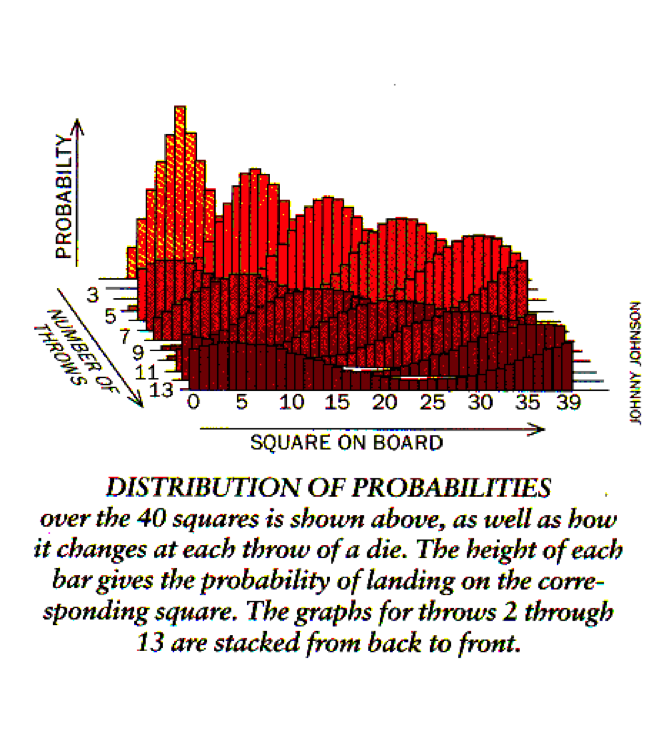


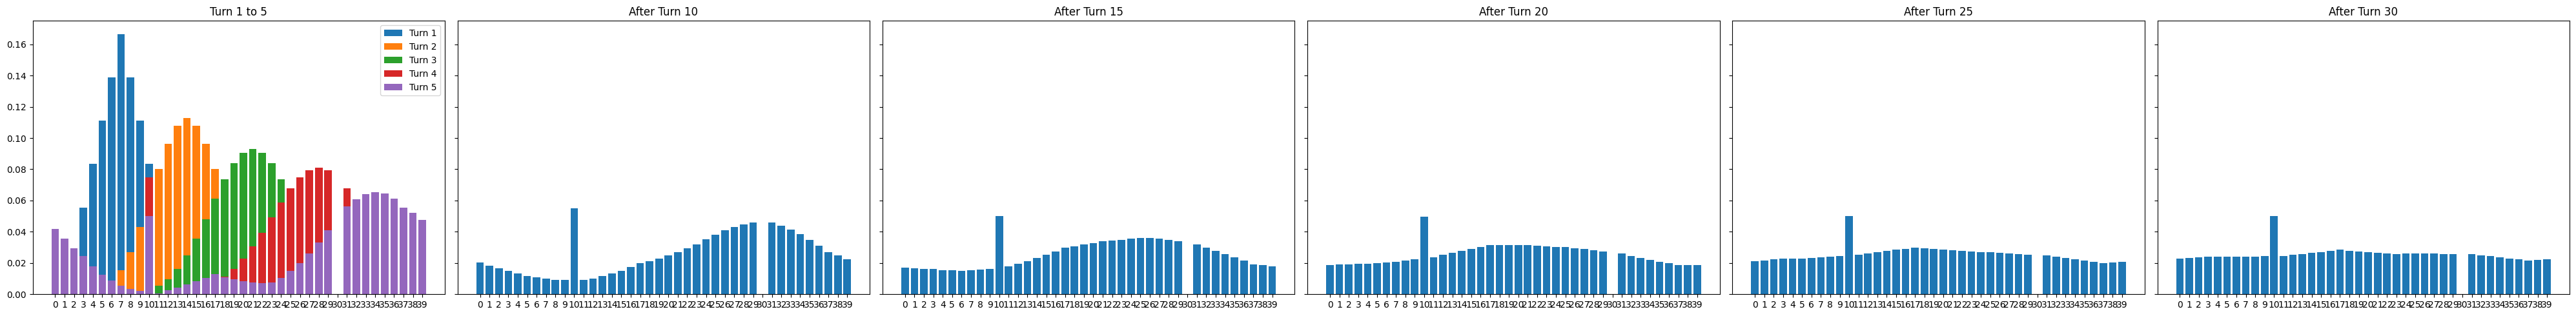

In [28]:
# we simulate N turns and plot the distribution at each turn
pi_tmp = pi.copy()
N = 30
plot_each_N = 5
fig, axes = plt.subplots(1, N // plot_each_N, figsize=(40,5), sharey=True)
for i in range(N):
    pi_tmp = pi_tmp @ A # update to get the next turns probability distribution
    if (i + 1) % plot_each_N == 0 or i < 5:
        axes[i // plot_each_N].bar(range(nsquares), pi_tmp.flatten())
        axes[i // plot_each_N].set_title(f'Turn 1 to 5' if i < 5 else f'After Turn {i + 1}')
        axes[i // plot_each_N].set_xticks(range(nsquares))
        axes[i // plot_each_N].set_xticklabels([i for i in range(nsquares)])
        if i == 4:
            # Add legend for first 5 turns
            axes[i // plot_each_N].legend([f'Turn {j+1}' for j in range(5)], loc='upper right')
plt.tight_layout()
plt.show()

# Interpretation:
# After a few turns, the probability distribution stabilizes and does not change significantly with more turns.
# We see no probability for state "Allez en Prison" as expected, the probability mass is moved to "Visite de Prison".
# We see an increased probability for squares right after "Visite de Prison" due to the jail rule.
# We see an decreased probability for squares right after "Allez en Prison" due to the jail rule.

## 3.a Computing the stationary distribution


Compute the stationary distribution $\mu$ of the Markov Chain, by using either one of the following properties:
 - $\lim_{n\rightarrow \infty} A^n = \mu$
 - $\mu \cdot A = \mu$. In other word $\mu$ is the eigenvector associated with the eigenvalue $1$.
 
Both can be obtained with the linear algebra functions of numpy. 

Verify that you get something similar to this image (this will not be exactly the same as it was obtained from a more detailled model):

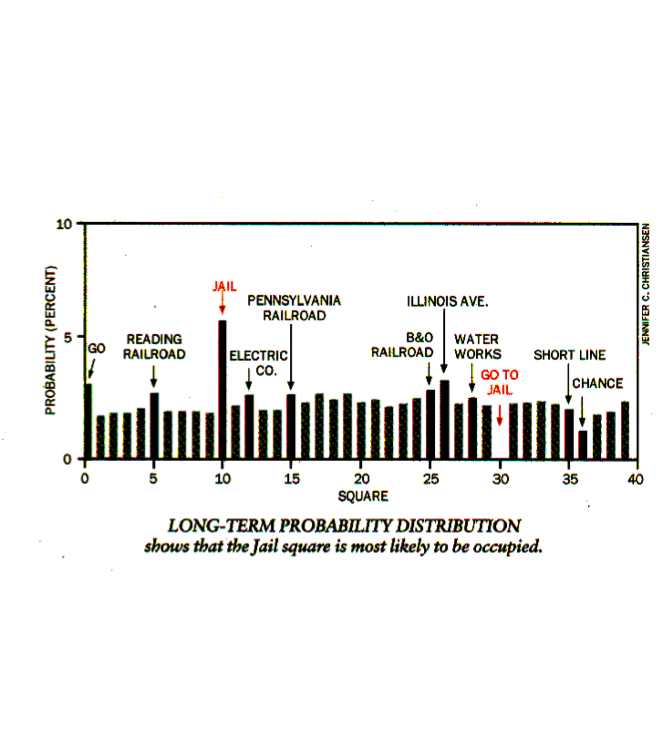


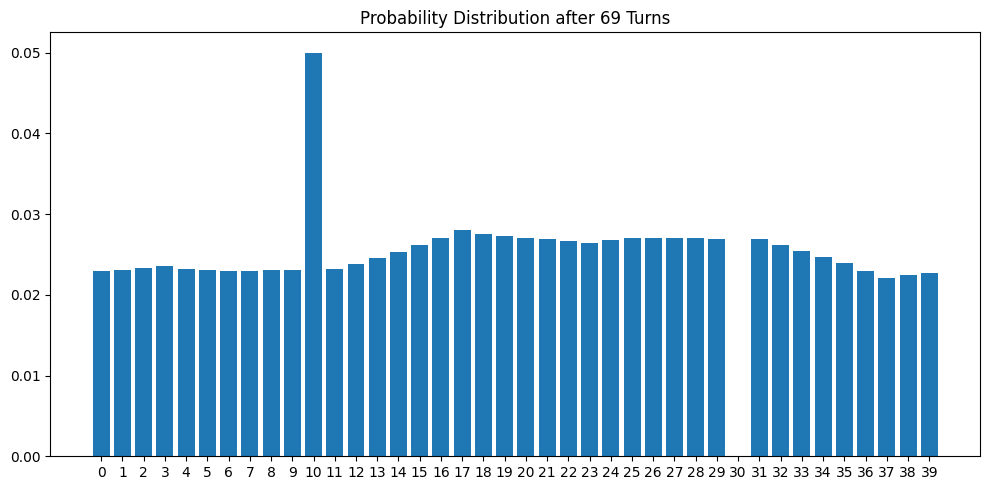

In [ ]:
# This is the same simulation as above but using matrix powers, however this is not necessarily the real stationary distribution. 
# The real stationary distribution is the limit of mu * A^n as n goes to infinity or the eigenvector of A with eigenvalue 1.
mu_end = np.linalg.matrix_power(A, 69)[0,:]

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.bar(range(nsquares), mu_end.flatten())
ax.set_title(f'Probability Distribution after 69 Turns')
ax.set_xticks(range(nsquares))
ax.set_xticklabels([i for i in range(nsquares)])
plt.tight_layout()
plt.show()

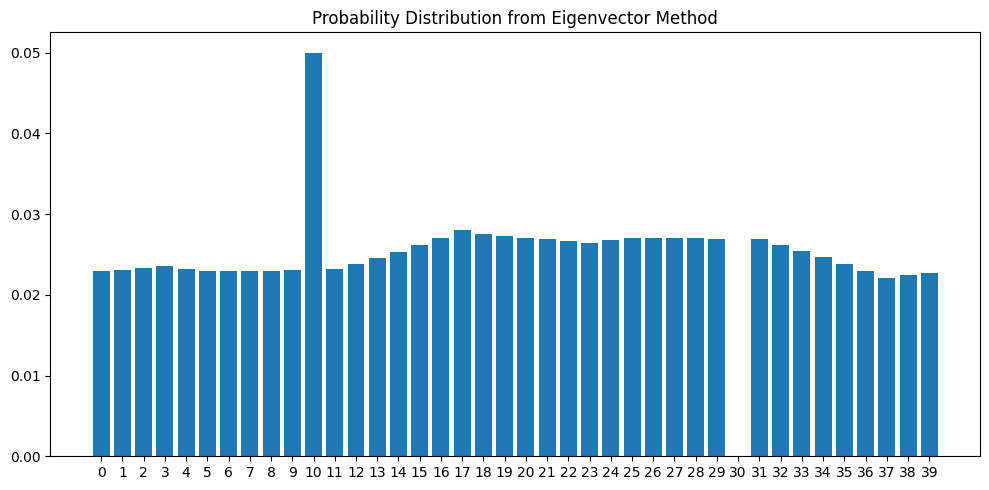

In [33]:
# Computing the stationary distribution via eigenvector method is more accurate and efficient.
eig_vals, eig_vecs = np.linalg.eig(A.T)
eig_val_1_idx = np.argmin(np.abs(eig_vals - 1.0)) # find index of eigenvalue closest to 1
mu_eig = np.real(eig_vecs[:, eig_val_1_idx]) # get corresponding eigenvector
mu_eig = mu_eig / np.sum(mu_eig) # normalize to get a probability distribution as eigenvectors are not necessarily unit vectors

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.bar(range(nsquares), mu_eig.flatten())
ax.set_title(f'Probability Distribution from Eigenvector Method')
ax.set_xticks(range(nsquares))
ax.set_xticklabels([i for i in range(nsquares)])
plt.tight_layout()
plt.show()

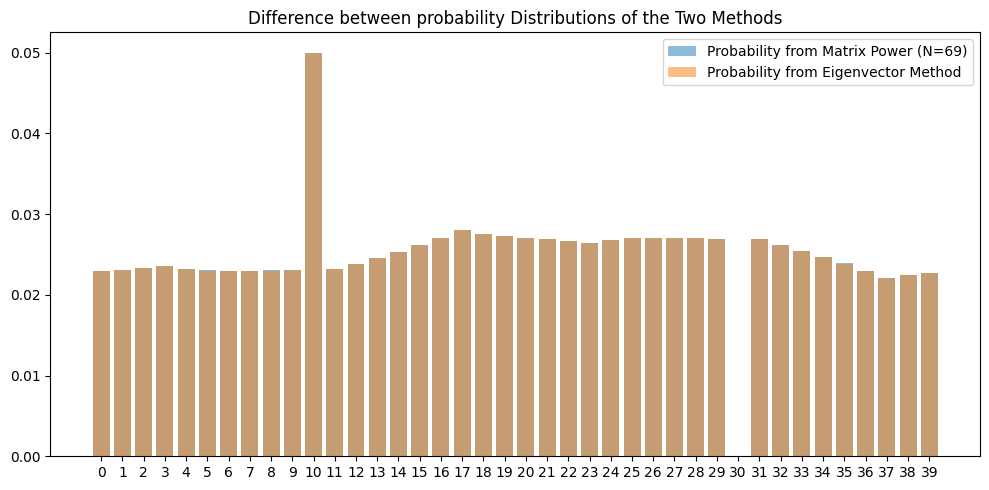

In [43]:
# Overlay the two distributions for comparison
# We do not see any notable difference between the two here.

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.bar(range(nsquares), mu_end.flatten(), alpha=0.5, label='Probability from Matrix Power (N=69)')
ax.bar(range(nsquares), mu_eig.flatten(), alpha=0.5, label='Probability from Eigenvector Method')
ax.set_title(f'Difference between probability Distributions of the Two Methods')
ax.set_xticks(range(nsquares))
ax.set_xticklabels([i for i in range(nsquares)])
ax.legend()
plt.tight_layout()
plt.show()

Can you explain why some locations are more visited than others?

> The "Visite de Prison" location is visited more often as the other ones as there is the field "Allez en Prison" that sends directly to this location, thus resulting in more combined probability. Resulting from this, the squares after "Visite de Prison" (i.e. "Gare de Lyon") are also more visited than the squares before.

## 3b. Convergence to the stationnary distribution

Use the successive powers of the matrix to determine the number of turns after which the chain converged to the stationary distribution (_e.g._ when the difference between the distribution of the rows of the matrix and the stationnary distribution is below 1%)



In [47]:
# we use relative difference to check how many multiplications are needed to converge to the eigenvector solution
def rel_diff(mu1, mu2):
    """
    The difference between two probability distributions mu1 and mu2 is computed as the maximum relative difference across all states.
    """
    maxs = np.maximum(mu1, mu2)
    abss = np.abs(mu1 - mu2)
    nonzero = maxs != 0
    return np.max(abss[nonzero] / maxs[nonzero])
    
mu_test = pi.copy()
count = 0
# succesively multiply until convergence (until relative difference is below threshold of 0.0004)
while rel_diff(mu_eig, mu_test) > 0.0004:
    mu_test = mu_test @ A
    count += 1
print(f'Convergence reached after {count} multiplications')

Convergence reached after 69 multiplications


## 3c. Evaluating investments   

We provide in attachment a table with all the incomes associated to the various properties of the board. Let's see how we can use that information to understand how to evaluate the various real estate investments on the board.

For each square $k$ of the monopoly, we thus know the cost $c_{k}$ of the property, the price $h_k$ of an house and the rent $r_{k,h}$ with $h$ houses. The total cost of a property with $h$ house is $c_{k,h}= c_k + h\cdot h_k$ 

1. Verify that the expected income per opponent turn on square $k$ is $i_{k,h} = \mu_k \cdot r_{k,h}$ and compute this value for all square and all number of houses. For instance a property where an opponent as 5% chance of landing with a rent of 100\$ provides an expected income per turn of 5\$.

2. Now an interesting quantity is the expected number of opponents turns before we are able to return on our investment with buying the property. For instance if the property mentionned in q.1 costed 50\$, given that we expect to earn 5\$ per turn with no house, our average waiting time before returning on our investment will be after $\frac{50}{5}=10$ opponent turns. Verify that the general formula for this value is:
$$
e_{k,h} = \frac{c_{k,h}} {i_{k,h}}
$$

3. compute $e_{k,h}$ for all square and all number of houses and check the most rentable properties, as a function of the number of houses.

4. (optional). Compute the expected number of turns to get a return of investment on a given color.


5. A classical recommendation for Monopoly is to buy orange properties, can you back up this claim?

In [97]:
# read monopoly square data in Monopoly_square_data.csv
df = pd.read_csv('./Data/Monopoly_squares_data.csv', index_col=0)
df["French Slots"] = squares
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index("French Slots")))
df = df[cols]

mu = mu_eig.flatten()

# --- 1. ---
# Compute i_k_h = mu * RENT_k_h which is the expected income per turn on square k with h houses
types = ["RENT_empty_property", "RENT_1house", "RENT_2houses", "RENT_3houses", "RENT_4houses", "RENT_hotel"]
for t in types:
    t_col = t.split("RENT_")[1]
    df[f"i_{t_col}"] = mu * df[t] # expected income per turn
    cols = df.columns.tolist()
    rent_idx = cols.index(t)
    i_rent_idx = cols.index(f"i_{t_col}")
    cols.insert(rent_idx + 1, cols.pop(i_rent_idx))
    df = df[cols]

# --- 2./3. ---
# Compute e_k_h = (Cost + house_cost * h) / i_k_h which is the expected number of turns to recoup the investment on square k with h houses
# how many times an opponent has to land on the property so that the income covers the investment
print("The most rentable properties to invest in are:")
for t in types:
    t_col = t.split("RENT_")[1]
    multiply = 0
    if t_col[0].isdigit():
        multiply = int(t_col[0])
    if "hotel" in t_col:
        multiply = 5 # 5 because a hotel is equivalent to 5 houses
    c = df[f"Cost"] + df[f"house_cost"] * multiply # total cost to build h houses/hotel
    df[f"e_{t_col}"] = c / df[f"i_{t_col}"] # expected turns to recoup investment
    cols = df.columns.tolist()
    i_rent_idx = cols.index(f"i_{t_col}")
    e_rent_idx = cols.index(f"e_{t_col}")
    cols.insert(i_rent_idx + 1, cols.pop(e_rent_idx))
    df = df[cols]
    print(f'Minimum e_{t_col:<15} is for {df.loc[df[f"e_{t_col}"].idxmin()]["French Slots"]:>15} after {round(df[f"e_{t_col}"].min(), 2):>10} turns')

# --- 4. ---
# Compute the expected number of turns to recoup the investment for a full color set
# You own a color set if you have bought all properties of that color
df["color"] = df.index.str.split(" ").str[:-1].str.join(" ")
df["i_color_set"] = mu * df["RENT_color_set"]
df["e_color_set"] = 0.0
for idx, row in df.iterrows():
    color = idx
    if not color.split(" ")[-1].isdigit():
        continue
    color_base = " ".join(color.split(" ")[:-1])

    cost = df[df["color"] == color_base]["Cost"].sum() # total cost for the color set
    i_color_sum = df[df["color"] == color_base]["i_color_set"].sum() # income sum for the color set
    if i_color_sum == 0:
        continue
    df.loc[idx, "e_color_set"] = cost / i_color_sum # expected turns to recoup investment for the color set

    cols = df.columns.tolist()
    rent_idx = cols.index("RENT_color_set")
    i_rent_idx = cols.index("i_color_set")
    e_rent_idx = cols.index("e_color_set")
    cols.insert(rent_idx + 1, cols.pop(i_rent_idx))
    cols.insert(rent_idx + 2, cols.pop(e_rent_idx))
    df = df[cols]

print("\nFull DataFrame with expected income and expected turns to recoup investment:")
display(df.reset_index(drop=True).set_index("French Slots").dropna().drop(columns=["color", "Cost", "house_cost"]))

color_df = df[["color", "e_color_set"]].drop_duplicates().reset_index(drop=True)
color_df = color_df[color_df["e_color_set"] > 0].reset_index(drop=True).drop_duplicates()
print("\nExpected turns to recoup investment for each color set:")
display(color_df)

print("\nMinimum and Second Minimum expected turns to recoup investment for color sets:", end=" ")
min_e_color = color_df.loc[color_df["e_color_set"].idxmin()]
print(f'Minimum e_color_set is for {min_e_color["color"]} with {min_e_color["e_color_set"]:.2f} turns')

The most rentable properties to invest in are:
Minimum e_empty_property  is for  Rue de la Paix after     351.93 turns
Minimum e_1house          is for  Rue La Fayette after     133.11 turns
Minimum e_2houses         is for  Rue La Fayette after      59.85 turns
Minimum e_3houses         is for   Place Pigalle after      30.56 turns
Minimum e_4houses         is for   Place Pigalle after       27.5 turns
Minimum e_hotel           is for   Place Pigalle after      25.67 turns

Full DataFrame with expected income and expected turns to recoup investment:


RENT_empty_property  i_empty_property  e_empty_property  RENT_color_set  i_color_set  e_color_set  RENT_1house  i_1house    e_1house  RENT_2houses  ...   e_2houses  RENT_3houses  i_3houses   e_3houses  RENT_4houses  i_4houses  e_4houses  RENT_hotel    i_hotel    e_hotel
French Slots                                                                                                                                                                   ...                                                                                                                       
Boulevard de Belleville                    2.0          0.046236       1297.685930             4.0     0.092472   426.974333         10.0  0.231181  475.818174          30.0  ...  230.699721          90.0   2.080627  100.931128         160.0   3.698892  70.291321       250.0   5.779519  53.637685
Rue Lecourbe                               4.0          0.094288        636.351447             8.0     0.188575   426.974333         20.0  0.471438  233.328864          60.0  ...  113.129146         180.0   4.242938   49.494001         320.0   7.543002  34.469037       450.0  10.607346  29.225029
Rue de Vaugirard                           6.0          0.137606        726.709998            12.0     0.275213   347.627221         30.0  0.688032  218.012999          90.0  ...   96.894666         270.0   6.192291   40.372778         400.0   9.173765  32.701950       550.0  12.613927  27.747109
Rue de Courcelles                          6.0          0.138024        724.509076            12.0     0.276049   347.627221         30.0  0.690122  217.352723          90.0  ...   96.601210         270.0   6.211102   40.250504         400.0   9.201633  32.602908       550.0  12.652245  27.663074
Avenue de la République                    8.0          0.184632        649.940867            16.0     0.369264   347.627221         40.0  0.923161  184.149912         100.0  ...   95.324660         300.0   6.923707   38.996452         450.0  10.385560  30.812011       600.0  13.847414  26.719791
Boulevard de la Villette                  10.0          0.231380        605.064783            20.0     0.462760   281.623765         50.0  1.156901  207.450783         150.0  ...   97.962870         450.0  10.412108   42.258493         625.0  14.461261  37.341141       750.0  17.353514  36.880139
Avenue de Neuilly                         10.0          0.245837        569.482423            20.0     0.491675   281.623765         50.0  1.229186  195.251116         150.0  ...   92.201916         450.0  11.062677   39.773376         625.0  15.364829  35.145201       750.0  18.437795  34.711310
Rue de Paradis                            12.0          0.303967        526.373575            24.0     0.607933   281.623765         60.0  1.519833  171.071412         180.0  ...   78.956036         500.0  12.665276   36.319777         700.0  17.731387  31.582414       900.0  22.797497  28.950547
Avenue Mozart                             14.0          0.377972        476.225128            28.0     0.755945   233.335613         70.0  1.889862  148.158929         200.0  ...   70.375491         550.0  14.848919   32.325584         750.0  20.248527  28.644060       950.0  25.648134  26.512650
Boulevard Saint-Michel                    14.0          0.385729        466.648383            28.0     0.771459   233.335613         70.0  1.928647  145.179497         200.0  ...   68.960261         550.0  15.153655   31.675527         750.0  20.664075  28.068036       950.0  26.174495  25.979489
Place Pigalle                             16.0          0.436286        458.414491            32.0     0.872573   233.335613         80.0  2.181432  137.524347         220.0  ...   66.678471         600.0  16.360739   30.560966         800.0  21.814319  27.504869      1000.0  27.267899  25.671211
Avenue Matignon                           18.0          0.483875        454.663198            36.0     0.967749   227.337490         90.0  2.419373  152.


Expected turns to recoup investment for each color set:


color  e_color_set
0       Brown   426.974333
1  Light Blue   347.627221
2        Pink   281.623765
3     Utility    84.266997
4      Orange   233.335613
5         Red   227.337490
6      Yellow   217.775973
7       Green   222.359465
8   Dark Blue   196.564723


Minimum and Second Minimum expected turns to recoup investment for color sets: Minimum e_color_set is for Utility with 84.27 turns


/tmp/ipykernel_373694/1123286013.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(prop_df["French Slots"], rotation=90)


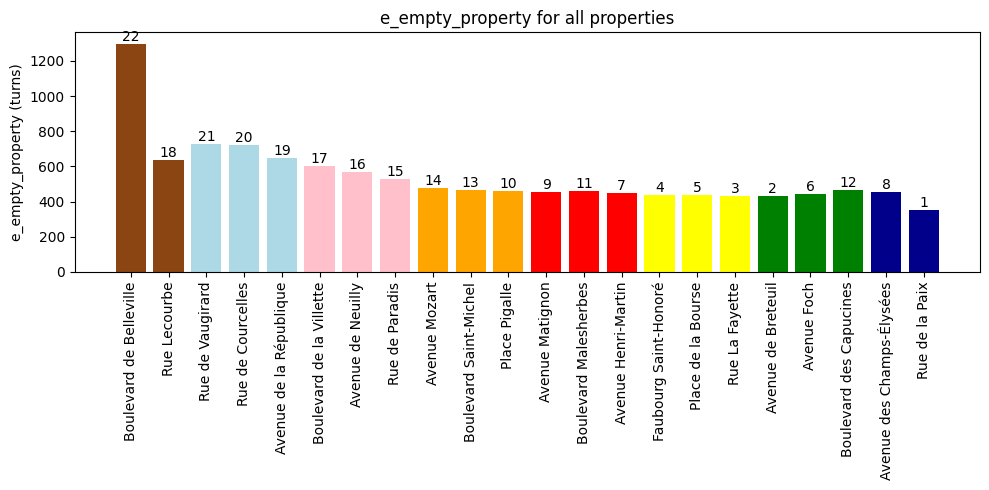

/tmp/ipykernel_373694/1123286013.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(prop_df["French Slots"], rotation=90)


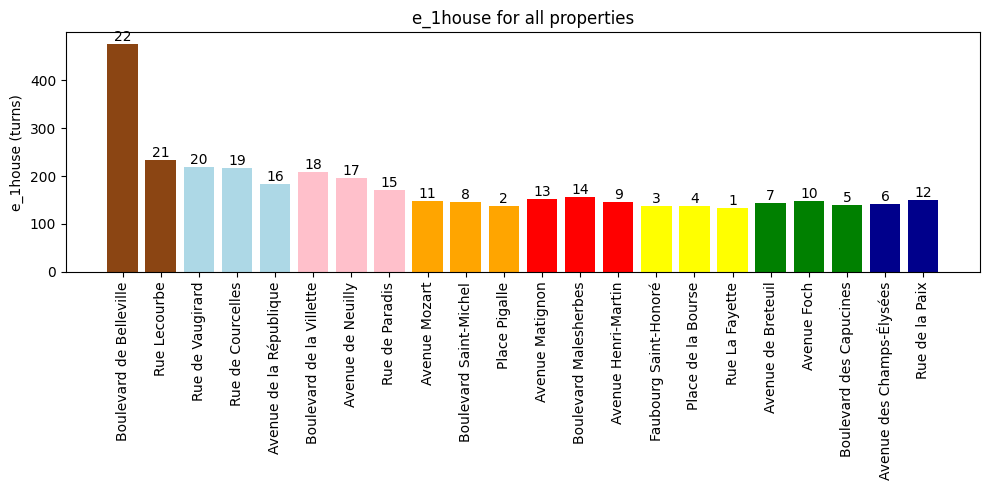

/tmp/ipykernel_373694/1123286013.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(prop_df["French Slots"], rotation=90)


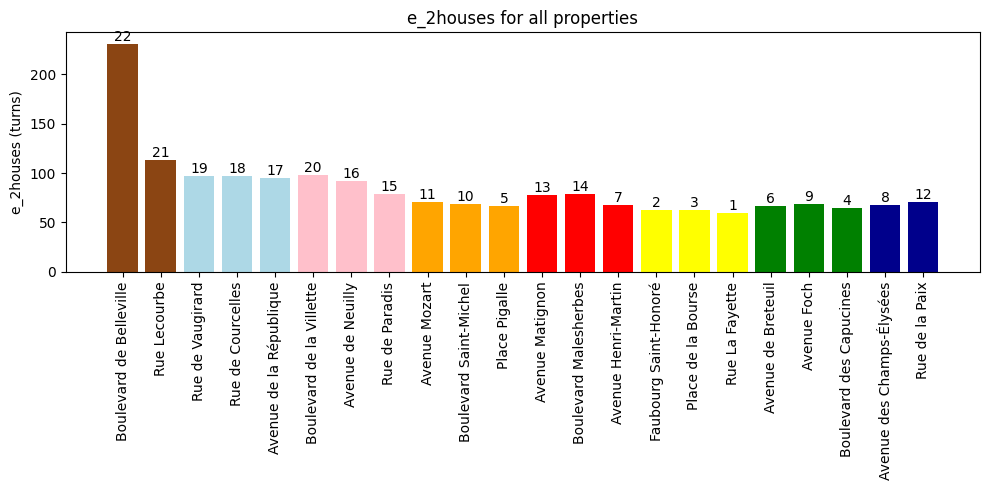

/tmp/ipykernel_373694/1123286013.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(prop_df["French Slots"], rotation=90)


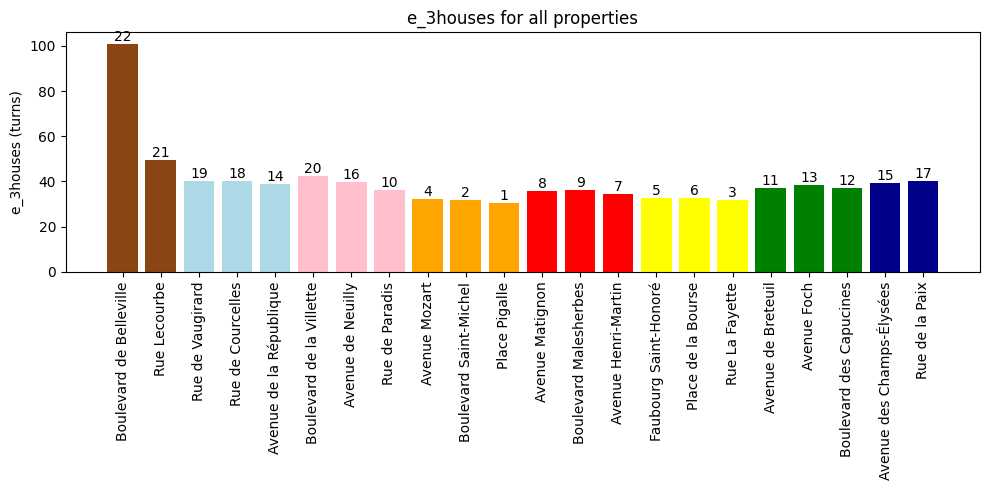

/tmp/ipykernel_373694/1123286013.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(prop_df["French Slots"], rotation=90)


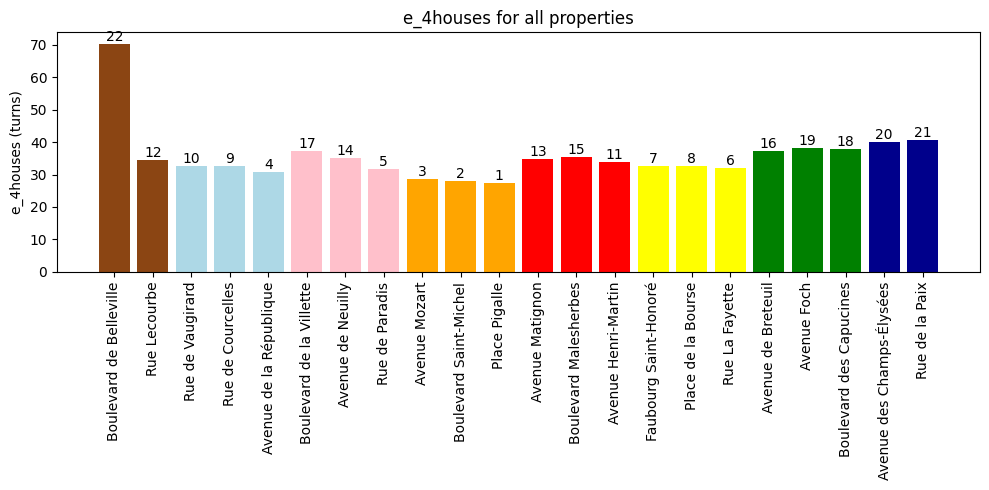

/tmp/ipykernel_373694/1123286013.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(prop_df["French Slots"], rotation=90)


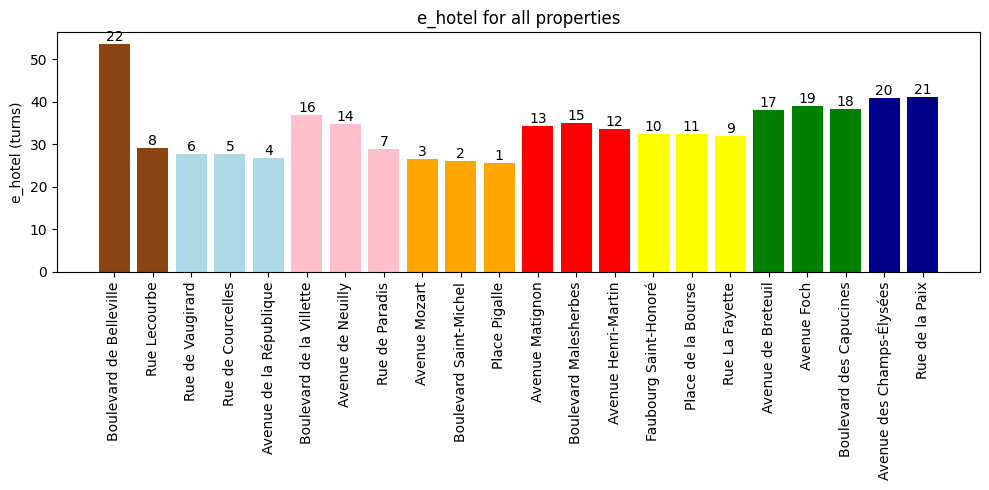

In [10]:
colors = {
    "Brown": "#8B4513",
    "Light Blue": "#ADD8E6",
    "Pink": "#FFC0CB",
    "Orange": "#FFA500",
    "Red": "#FF0000",
    "Yellow": "#FFFF00",
    "Green": "#008000",
    "Dark Blue": "#00008B"
}

types = ["empty_property", "1house", "2houses", "3houses", "4houses", "hotel"]
for t_col in types:
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    prop_df = df[~df[f"e_{t_col}"].isna()]
    # color them after the color column
    ax.bar(prop_df["French Slots"], prop_df[f"e_{t_col}"], color=prop_df["color"].map(colors))
    ax.set_title(f'e_{t_col} for all properties')
    ax.set_xticklabels(prop_df["French Slots"], rotation=90)
    ax.set_ylabel(f'e_{t_col} (turns)')
    # add the order index on top of each bar, lowest e_k_h gets 1, second lowest gets 2, etc.
    order_idxs = prop_df[f"e_{t_col}"].rank(method='min').astype(int)
    for i, order_idx in enumerate(order_idxs):
        ax.text(i, prop_df[f"e_{t_col}"].iloc[i], str(order_idx), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()
    

> The claim that orange properties are the best investment can be backed up by looking at $e$ as the expected number of turns to get a return of investment on property. However this only applies to 4 houses or hotel investments. For 3 houses yellow can compete with orange. For two houses or less, yellow has generally a lower $e$ than orange, making it a better investment.

## 4. Improving the model

By using the article provided on the moodle (also reproduced [at this adress](http://www.math.yorku.ca/Who/Faculty/Steprans/Courses/2042/Monopoly/Stewart4.html)), design a more realistic transition matrix that would take into account double on the dice as well as the traditional getting out of jail.

You will integrate the following ingredients:
  - Double allow the player to do a second roll.
  - After three double the player goes to jail.
  - To simplify, we also hypothesize that the player cannot buy properties on the intermediate squares in a serie of doubles. 
  - Player always try to get out of jail by throwing the dice up to three times
  - (optional) Account for the cards in Chance and community chests that redirect the token to other cases (more details are given in the article and you can look online what are the statistics for the cards)

To take this information into account in the Markov chain you can increase the state space by consider for each square the number of doubles you did when you landed on it. So now each square will correspond to 3 states in the Markov chain, the ID of the square, together with an additional field that stores the information about the number of doubles. 

For instance imagine you start from (0, "Départ"):
  - if you throw two 3, that's a double and you will land on square 6 ("Rue de Vaugirard") while keeping the information that you did a double so you will be in state (1, "Rue de Vaugirard"). 
  - if you throw a 2 and a 4, that's not a double and you will land on state (0, "Rue de Vaugirard").

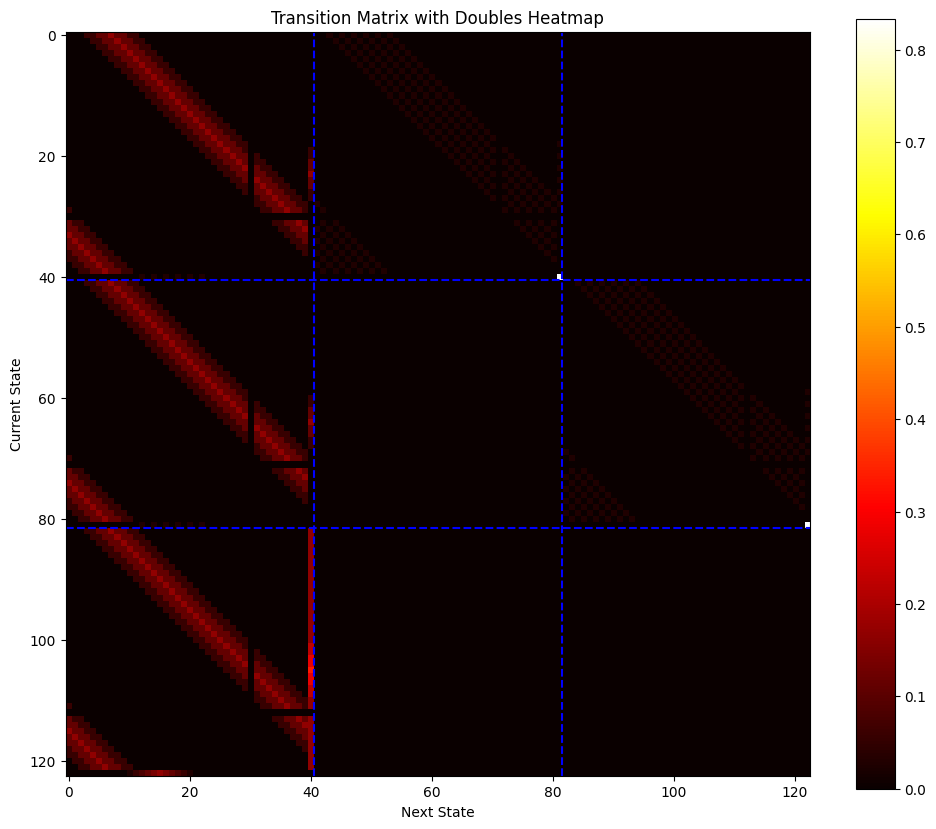

In [104]:
squares = [
    "Départ",
    "Boulevard de Belleville",
    "Caisse de Communauté-1",
    "Rue Lecourbe",
    "Impôts sur le Revenu",
    "Gare Montparnasse",
    "Rue de Vaugirard",
    "Chance-1",
    "Rue de Courcelles",
    "Avenue de la République",
    "Visite de Prison", # Just Visiting and being in Jail are the same square here
    "Boulevard de la Villette",
    "Compagnie de Distribution d Électricité",
    "Avenue de Neuilly",
    "Rue de Paradis",
    "Gare de Lyon",
    "Avenue Mozart",
    "Caisse de Communauté-2",
    "Boulevard Saint-Michel",
    "Place Pigalle",
    "Parc Gratuit",
    "Avenue Matignon",
    "Chance-2",
    "Boulevard Malesherbes",
    "Avenue Henri-Martin",
    "Gare du Nord",
    "Faubourg Saint-Honoré",
    "Place de la Bourse",
    "Compagnie de Distribution des Eaux",
    "Rue La Fayette",
    "Allez en Prison", # Go to Jail
    "Avenue de Breteuil",
    "Avenue Foch",
    "Caisse de communauté-3",
    "Boulevard des Capucines",
    "Gare Saint-Lazare",
    "Chance-3",
    "Avenue des Champs-Élysées",
    "Taxe de Luxe",
    "Rue de la Paix",
    "Prision"
]

nsquares = len(squares) - 1 # exclude the "Prision" square for the main board, adding it as a separate state for being in jail
dict_squares = dict((x, i) for i, x in enumerate(squares))
iprison = dict_squares["Allez en Prison"] 
ivisite = dict_squares["Visite de Prison"]

# Probability distribution of the sum of two dices, e.g. P(2)=1/36, P(3)=2/36, ..., P(12)=1/36
TwoDices = np.convolve(np.ones(6)/6, np.ones(6)/6)
# Probability of rolling doubles with two dices, e.g. P(2 with doubles)=1, P(3 with doubles)=0, P(4 with doubles)=1/3, ..., P(12 with doubles)=1
TwoDicesDouble = np.array([1, 0, 1/3, 0, 1/5, 0, 1/5, 0, 1/3, 0, 1])
# Probability of not rolling any doubles
not_double = (1 - TwoDicesDouble) * TwoDices
# Probability of rolling doubles
double = TwoDicesDouble * TwoDices


# We are building a large transition matrix from sub-matrices, where the sub-matrices are:
#   1  2  3
# 1 m1 m2 m3
# 2 m4 m5 m6
# 3 m7 m8 m9
# The first row of sub-matrices corresponds to having rolled no doubles yet, thus the first roll in the players turn
# the second row corresponds to having rolled one double, thus the second roll in the players turn
# and the third row corresponds to having rolled two doubles, transitioning to jail on the third double roll.

# The sub-matrix (1,1) (m1) is the transition matrix when no doubles have been rolled yet
m1 = np.zeros((nsquares, nsquares), dtype=np.float64)
tmp = np.zeros(nsquares, dtype=np.float64)
tmp[:11] = not_double # rolling no doubles and moving accordingly
for i in range(nsquares):
    if i == iprison:
        continue
    m1[i,] = np.roll(tmp, i+2) # +2 because TwoDices starts at sum=2 (minimal dice roll)

# Add a prison logic: move probability mass from "Allez en Prison" to "Visite de Prison"
tmp = m1.copy()
m1 = np.zeros((nsquares+1, nsquares+1), dtype=np.float64)
m1[:nsquares, :nsquares] = tmp

m1[:, -1] += m1[:, iprison] # if we land on "Allez en Prison", we go to jail (the last state (-1 index))
m1[:, iprison] = 0.0 # zero out the "Allez en Prison" column
m1[-1, (ivisite+2):(ivisite+13)] = double # from jail, if we roll doubles, we move accordingly

# The sub-matrix (1,2) (m2) is the transition matrix when one double has been rolled
m2 = np.zeros((nsquares, nsquares), dtype=np.float64)
tmp = np.zeros(nsquares, dtype=np.float64)
tmp[:11] = double
for i in range(nsquares):
    if i == iprison:
        continue
    m2[i,] = np.roll(tmp, i+2)

tmp = m2.copy()
m2 = np.zeros((nsquares+1, nsquares+1), dtype=np.float64)
m2[:nsquares, :nsquares] = tmp

m2[:, -1] += m2[:, iprison] # if we land on "Allez en Prison", we go to jail (the last state (-1 index))
m2[:, iprison] = 0.0 # zero out the "Allez en Prison" column
m2[-1, -1] = 30/36  # we stay in prison with 30/36 probability, as we faild to roll doubles to get out of jail, transitioning to state first double

# The sub-matrix (1,3) (m3) is 0 as you can't transition to a third double state if you havn't rolled any double beforehand
m3 = np.zeros((nsquares+1, nsquares+1), dtype=np.float64)

# The sub-matrix (2,1) (m4) is the same as (1,1) (m1), because after rolling one double, the next roll is like starting fresh
m4 = m1.copy()

# The sub-matrix (2,2) (m5) is 0 as you can't transition to a first double state from having rolled one double
m5 = np.zeros((nsquares+1, nsquares+1), dtype=np.float64)

# The sub-matrix (2,3) (m6) is the same as (1,2) (m2), as another double has been rolled
m6 = m2.copy()

# The sub-matrix (3,1) (m7) is the same as m1=m4 with the addition that rolling any outcome sends you to jail
m7 = m4.copy()

m7[:, -1] += 6/36 # go to prison with 6/36 probability as you throw doubles three times in a row
m7[iprison, -1] = 0 
m7[-1, :] = 0 # 
m7[-1, ivisite:ivisite+11] = TwoDices # we roll "normal" from jail, as we either pay 50$ or roll a double to get out of jail

# The sub-matrix (3,2) (m8) is 0 as you cant go back to first double states from second double state
m8 = np.zeros((nsquares+1, nsquares+1), dtype=np.float64)

# The sub-matrix (3,3) (m9) is 0 as you cant go into third double states from second double states as you go to jail
m9 = np.zeros((nsquares+1, nsquares+1), dtype=np.float64)

# Combine the sub-matrices into the full transition matrix
mbaba = np.zeros((3*(nsquares+1), 3*(nsquares+1)), dtype=np.float64)
mbaba[0:nsquares+1, 0:nsquares+1] = m1
mbaba[0:nsquares+1, nsquares+1:2*(nsquares+1)] = m2
mbaba[0:nsquares+1, 2*(nsquares+1):3*(nsquares+1)] = m3
mbaba[nsquares+1:2*(nsquares+1), 0:nsquares+1] = m4
mbaba[nsquares+1:2*(nsquares+1), nsquares+1:2*(nsquares+1)] = m5
mbaba[nsquares+1:2*(nsquares+1), 2*(nsquares+1):3*(nsquares+1)] = m6
mbaba[2*(nsquares+1):3*(nsquares+1), 0:nsquares+1] = m7
mbaba[2*(nsquares+1):3*(nsquares+1), nsquares+1:2*(nsquares+1)] = m8
mbaba[2*(nsquares+1):3*(nsquares+1), 2*(nsquares+1):3*(nsquares+1)] = m9


pi = np.zeros((1, 3*(nsquares+1)))
pi[0,0] = 1


# visualize transition matrix
plt.figure(figsize=(12,10))
plt.imshow(mbaba, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Transition Matrix with Doubles Heatmap")
plt.xlabel("Next State")
plt.ylabel("Current State")
# make the sub-matrix boundaries visible
for i in range(1, 3):
    plt.axhline(y=i*(nsquares+1)-0.5, color='blue', linestyle='--')
    plt.axvline(x=i*(nsquares+1)-0.5, color='blue', linestyle='--')


plt.show()



Recompute the values of question 2 and 3a with this new matrix and comment on possible difference.

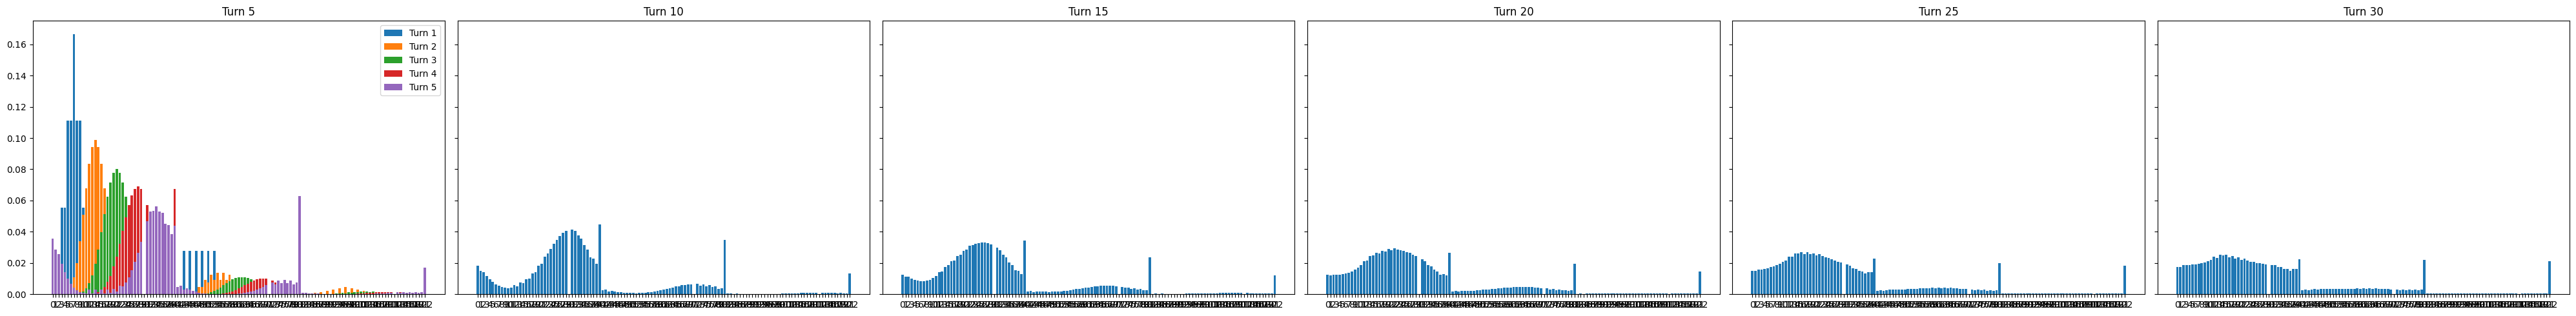

In [116]:

pi_tmp = pi.copy()
N = 30
plot_each_N = 5
fig, axes = plt.subplots(1, N // plot_each_N, figsize=(40,5), sharey=True)
for i in range(N):
    pi_tmp = pi_tmp @ mbaba
    if (i + 1) % plot_each_N == 0 or i < 5:
        axes[i // plot_each_N].bar(range(3*(nsquares+1)), pi_tmp.flatten())
        axes[i // plot_each_N].set_title(f'Turn {i + 1}')
        axes[i // plot_each_N].set_xticks(range(3*(nsquares+1)))
        axes[i // plot_each_N].set_xticklabels([i for i in range(3*(nsquares+1))])
        if i == 4:
            # Add legend for first 5 turns
            axes[i // plot_each_N].legend([f'Turn {j+1}' for j in range(5)], loc='upper right')
plt.tight_layout()
plt.show()

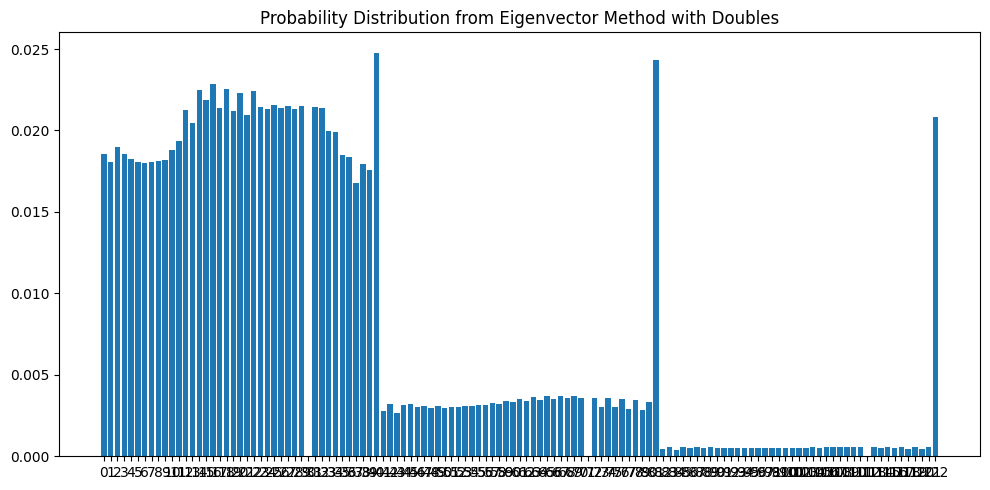

In [112]:
eig_vals, eig_vecs = np.linalg.eig(mbaba.T)
eig_val_1_idx = np.argmin(np.abs(eig_vals - 1.0))
mu_eig = np.real(eig_vecs[:, eig_val_1_idx])
mu_eig = mu_eig / np.sum(mu_eig)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.bar(range(3*(nsquares+1)), mu_eig.flatten())
ax.set_title(f'Probability Distribution from Eigenvector Method with Doubles')
ax.set_xticks(range(3*(nsquares+1)))
ax.set_xticklabels([i for i in range(3*(nsquares+1))])
plt.tight_layout()
plt.show()


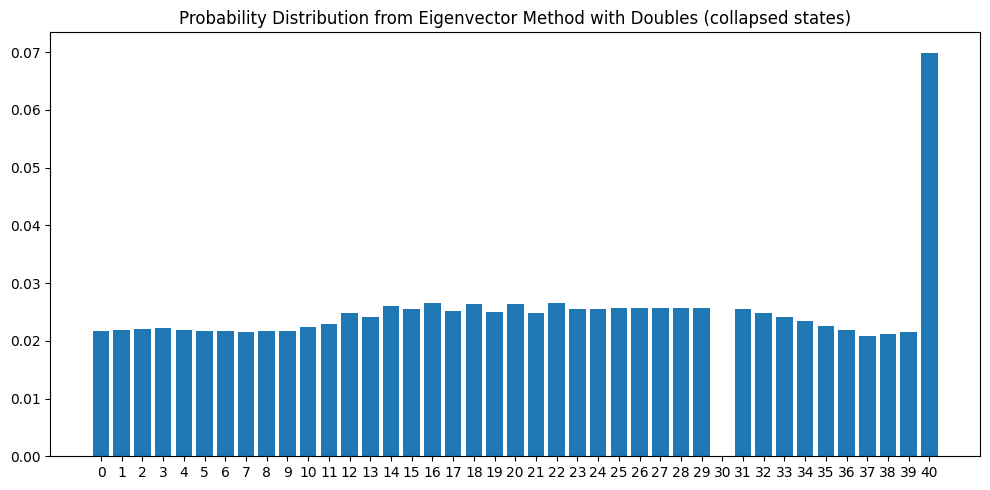

In [113]:

mu_eig_eingeklappt = np.zeros((nsquares+1,), dtype=np.float64)
for i in range(3):
    mu_eig_eingeklappt += mu_eig[i*(nsquares+1):(i+1)*(nsquares+1)]

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.bar(range(nsquares+1), mu_eig_eingeklappt.flatten())
ax.set_title(f'Probability Distribution from Eigenvector Method with Doubles (collapsed states)')
ax.set_xticks(range(nsquares+1))
ax.set_xticklabels([i for i in range(nsquares+1)])
plt.tight_layout()
plt.show()


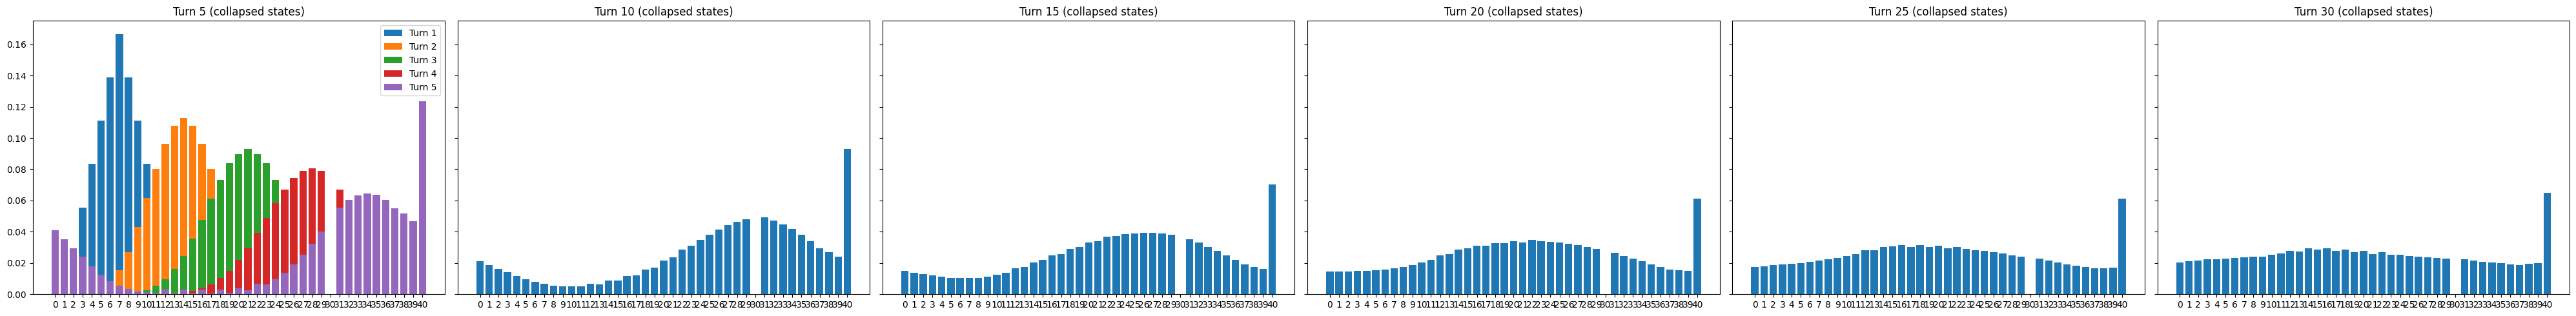

In [117]:

pi_tmp = pi.copy()
N = 30
plot_each_N = 5
fig, axes = plt.subplots(1, N // plot_each_N, figsize=(40,5), sharey=True)
for i in range(N):
    pi_tmp = pi_tmp @ mbaba
    if (i + 1) % plot_each_N == 0 or i < 5:
        pi_tmp = pi_tmp.flatten()
        pi_tmp_eingeklappt = pi_tmp[:nsquares+1] + pi_tmp[nsquares+1:2*(nsquares+1)] + pi_tmp[2*(nsquares+1):3*(nsquares+1)]
        axes[i // plot_each_N].bar(range(nsquares+1), pi_tmp_eingeklappt.flatten())
        axes[i // plot_each_N].set_title(f'Turn {i + 1} (collapsed states)')
        axes[i // plot_each_N].set_xticks(range(nsquares+1))
        axes[i // plot_each_N].set_xticklabels([i for i in range(nsquares+1)])
        if i == 4:
            # Add legend for first 5 turns
            axes[i // plot_each_N].legend([f'Turn {j+1}' for j in range(5)], loc='upper right')
plt.tight_layout()
plt.show()

In [118]:
out_dir = "./monopoly_gif_frames"
os.makedirs(out_dir, exist_ok=True)

pi_tmp = pi.copy()
N = 100
plot_each_N = 1
saved_frames = []
for i in range(N):
    pi_tmp = pi_tmp @ mbaba
    if (i + 1) % plot_each_N == 0:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        pi_flat = pi_tmp.flatten()
        pi_e = (pi_flat[:nsquares+1] +
                pi_flat[nsquares+1:2*(nsquares+1)] +
                pi_flat[2*(nsquares+1):3*(nsquares+1)])
        ax.bar(range(nsquares+1), pi_e.flatten())
        ax.set_title(f"Turn {i + 1}")
        ax.set_xticks(range(nsquares+1))
        ax.set_xticklabels([j for j in range(nsquares+1)])
        plt.tight_layout()
        frame_path = os.path.join(out_dir, f"frame_{i+1:03d}.png")
        fig.savefig(frame_path, dpi=120)
        plt.close(fig)
        saved_frames.append(frame_path)

gif_path = "./monopoly_eingeklappt.gif"

frames = [Image.open(fp) for fp in saved_frames]
frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0
)

print(f"Saved GIF to {gif_path}")

Saved GIF to ./monopoly_eingeklappt.gif



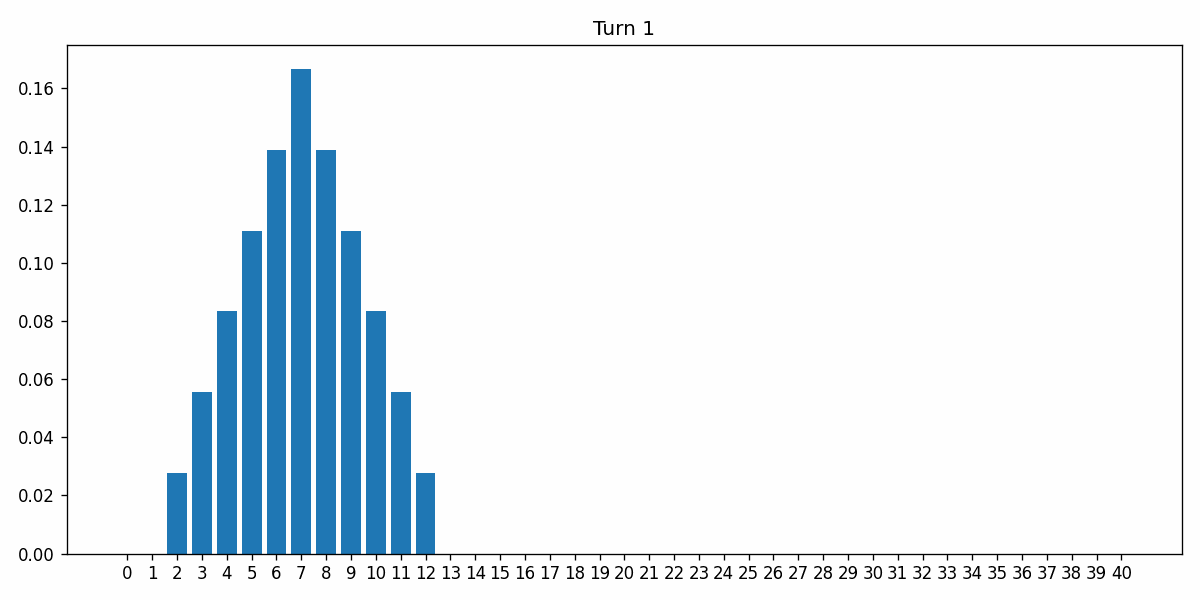

In [134]:
import base64
with open(gif_path, "rb") as f:
    gif_data = f.read()
gif_base64 = base64.b64encode(gif_data).decode("utf-8")
from IPython.display import HTML
HTML(f'<img src="data:image/gif;base64,{gif_base64}">')         

In [ ]:
out_dir = "./monopoly_gif_frames_collapsed"
os.makedirs(out_dir, exist_ok=True)

m_tmp = mbaba.copy()
N = 100
saved_frames = []
for i in range(N):
    print(f"Multiplication {i + 1}/{N}", end="\r")
    m_tmp = m_tmp @ mbaba
    if (i + 1) % plot_each_N == 0:
        # visualize m_tmp collapsed
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        m_e = np.zeros((nsquares+1, nsquares+1), dtype=np.float64)
        for r in range(3):
            for c in range(3):
                m_e += m_tmp[r*(nsquares+1):(r+1)*(nsquares+1), c*(nsquares+1):(c+1)*(nsquares+1)]
        ax.imshow(m_e, cmap='hot', interpolation='nearest')
        ax.set_title(f'Transition Matrix after {i + 1} Multiplications (collapsed states)')
        ax.set_xlabel("Next State")
        ax.set_ylabel("Current State")
        ax.set_xticks(ticks=np.arange(nsquares+1), labels=[i for i in range(nsquares+1)], rotation=90)
        ax.set_yticks(ticks=np.arange(nsquares+1), labels=[i for i in range(nsquares+1)])
        plt.tight_layout()
        frame_path = os.path.join(out_dir, f"matrix_frame_{i+1:03d}.png")
        fig.savefig(frame_path, dpi=120)
        plt.close(fig)
        saved_frames.append(frame_path)

gif_path = "./monopoly_A_collapsed.gif"

frames = [Image.open(fp) for fp in saved_frames]
frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0
)

print(f"Saved GIF to {gif_path}")

Saved GIF to ./monopoly_collapsed.gif



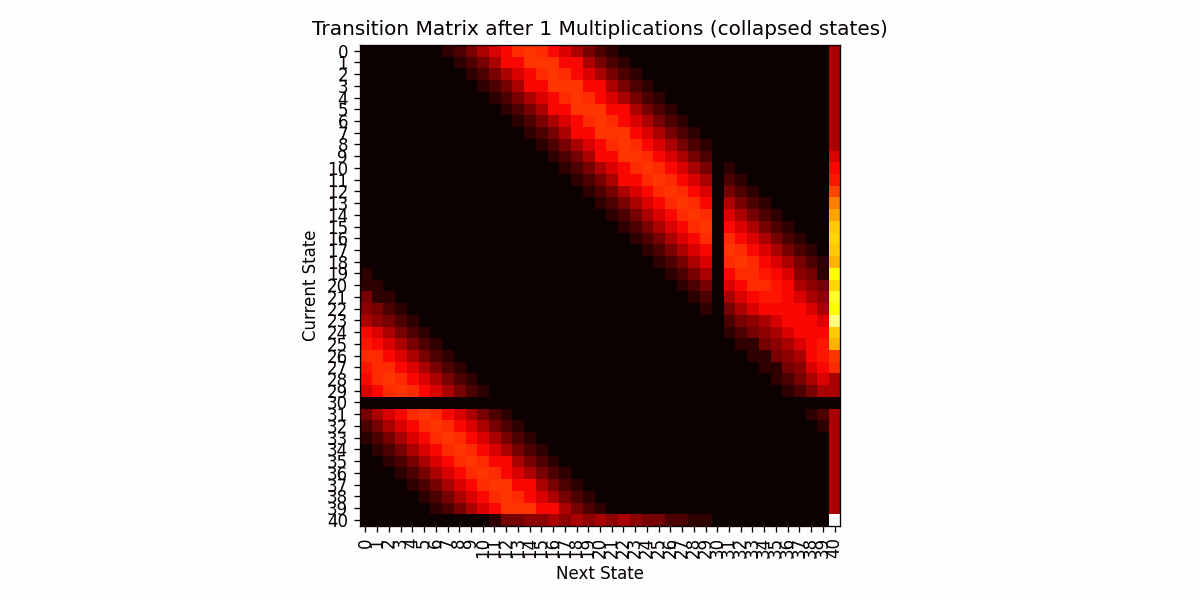

In [143]:
import base64
with open(gif_path, "rb") as f:
    gif_data = f.read()
gif_base64 = base64.b64encode(gif_data).decode("utf-8")
from IPython.display import HTML
HTML(f'<img src="data:image/gif;base64,{gif_base64}">')         

In [ ]:
out_dir = "./monopoly_gif_frames_A"
os.makedirs(out_dir, exist_ok=True)

m_tmp = mbaba.copy()
N = 100
saved_frames = []
for i in range(N):
    print(f"Multiplication {i + 1}/{N}", end="\r")
    m_tmp = m_tmp @ mbaba
    if (i + 1) % plot_each_N == 0:
        # visualize m_tmp collapsed
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.imshow(m_tmp, cmap='hot', interpolation='nearest')
        ax.set_title(f'Transition Matrix after {i + 1} Multiplications (collapsed states)')
        ax.set_xlabel("Next State")
        ax.set_ylabel("Current State")
        ax.set_xticks(ticks=np.arange(3*(nsquares+1)), labels=[i for i in range(3*(nsquares+1))], rotation=90)
        ax.set_yticks(ticks=np.arange(3*(nsquares+1)), labels=[i for i in range(3*(nsquares+1))])
        plt.tight_layout()
        frame_path = os.path.join(out_dir, f"matrix_frame_{i+1:03d}.png")
        fig.savefig(frame_path, dpi=120)
        plt.close(fig)
        saved_frames.append(frame_path)

gif_path = "./monopoly_A.gif"

frames = [Image.open(fp) for fp in saved_frames]
frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0
)

print(f"Saved GIF to {gif_path}")

Saved GIF to ./monopoly_A.gif



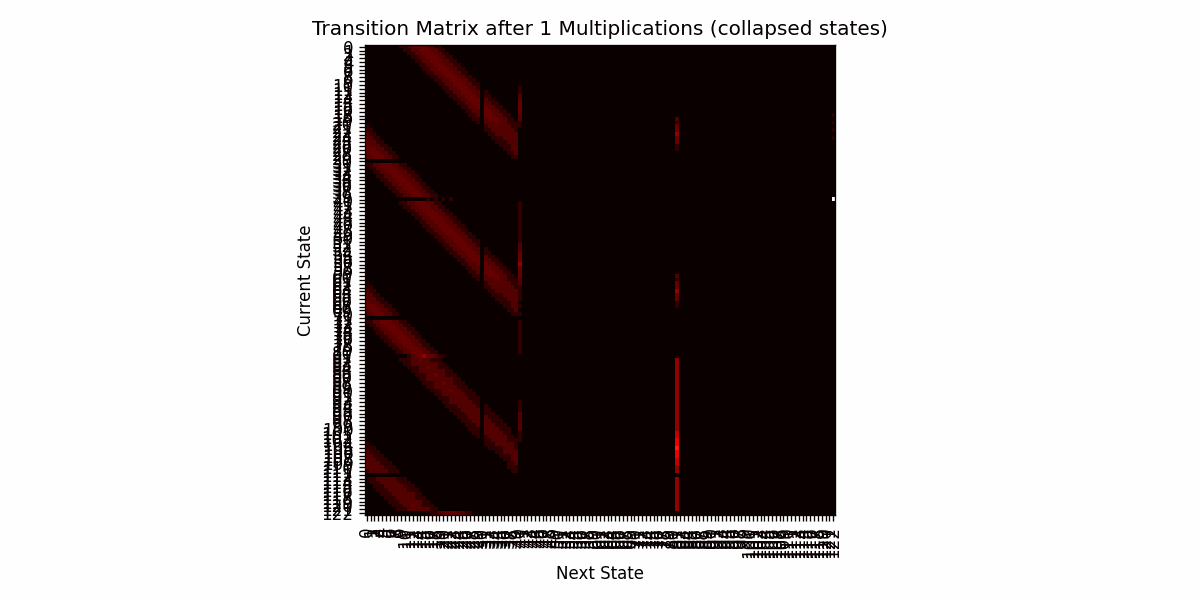

In [146]:
import base64
with open(gif_path, "rb") as f:
    gif_data = f.read()
gif_base64 = base64.b64encode(gif_data).decode("utf-8")
from IPython.display import HTML
HTML(f'<img src="data:image/gif;base64,{gif_base64}">')